In [424]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [425]:
sns.set_theme(style='whitegrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Leitura e pré-processamento de dados.

In [426]:
df = pd.read_csv('data/Florida NREL 2023.csv', skiprows=2)
df.head(10)

,Year,Month,Day,Hour,Minute,Temperature,Alpha,Aerosol Optical Depth,Asymmetry,Clearsky DHI,...,GHI,Ozone,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
0,2020,1,1,0,30,12.8,1.43,0.052,0.65,0,...,0,0.249,78.01,113.56,0.92,0.16,1015,1.8,294,1.3
1,2020,1,1,1,30,11.9,1.44,0.048,0.65,0,...,0,0.250,79.01,126.47,0.92,0.16,1015,1.8,294,1.4
2,2020,1,1,2,30,11.3,1.44,0.045,0.65,0,...,0,0.252,79.58,139.58,0.91,0.16,1015,1.8,296,1.4
3,2020,1,1,3,30,10.8,1.43,0.045,0.65,0,...,0,0.252,80.53,152.75,0.92,0.16,1015,1.9,299,1.4
4,2020,1,1,4,30,10.6,1.42,0.046,0.65,0,...,0,0.252,80.77,165.68,0.92,0.16,1015,2.1,302,1.5
5,2020,1,1,5,30,10.6,1.40,0.052,0.65,0,...,0,0.252,80.46,174.60,0.93,0.16,1015,2.2,308,1.6
6,2020,1,1,6,30,10.4,1.41,0.057,0.65,0,...,0,0.252,82.58,165.26,0.93,0.16,1015,2.2,315,1.6
7,2020,1,1,7,30,9.9,1.44,0.055,0.65,0,...,0,0.251,83.70,152.31,0.93,0.16,1014,2.0,323,1.4
8,2020,1,1,8,30,9.4,1.45,0.051,0.65,0,...,0,0.252,85.26,139.13,0.93,0.16,1014,1.9,328,1.4
9,2020,1,1,9,30,9.1,1.45,0.048,0.65,0,...,0,0.252,85.85,126.02,0.92,0.16,1014,1.9,331,1.4


In [427]:
def data_preprocessing(df):
    df = df.drop(['Minute','Cloud Type', 'Ozone','Solar Zenith Angle', 'Surface Albedo',
                    'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'DHI', 'DNI', 'Fill Flag', 'Cloud Fill Flag', 'Aerosol Optical Depth','Alpha','SSA','Asymmetry'], axis = 1)
    df = df.dropna()
    # Combine year, month, day, hour into a single datetime column
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    # Extract useful time-based features
    df['DayOfYear'] = df['Datetime'].dt.dayofyear
    df['HourOfDay'] = df['Datetime'].dt.hour
    df['Month'] = df['Datetime'].dt.month
    # Optionally, drop original columns if not needed
    df = df.drop(['Month', 'Day', 'Hour', 'Datetime'], axis=1)
    return df

In [428]:
def data_preprocessing_scaling_split(df):
    scaler = MinMaxScaler()
    columns_to_scale = [col for col in df.columns if col not in ['Year', 'DayOfYear', 'HourOfDay']]
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    # Use the 2022 data for testing
    df_train = df[df['Year'] < 2022]
    df_test = df[df['Year'] == 2022]
    #Drop the 'Year' column from both train and test sets
    df_train = df_train.drop(['Year'], axis=1)
    df_test = df_test.drop(['Year'], axis=1)
    # Reset index for both dataframes
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    return df_train, df_test

In [429]:
df = data_preprocessing(df)
df.tail(10)

,Year,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,DayOfYear,HourOfDay
8750,2016,16.7,6.3,385,50.32,1021,1.4,108,2.7,366,14
8751,2016,20.3,8.7,535,47.38,1020,1.6,131,3.7,366,15
8752,2016,22.2,9.6,631,44.78,1019,1.7,141,3.6,366,16
8753,2016,23.3,9.9,660,42.76,1018,1.9,147,3.3,366,17
8754,2016,23.8,9.9,622,41.37,1017,2.0,151,3.2,366,18
8755,2016,23.8,9.8,521,41.00,1016,2.1,152,3.2,366,19
8756,2016,23.2,9.8,367,42.57,1016,2.2,151,2.8,366,20
8757,2016,20.6,10.4,179,52.12,1016,2.2,145,1.9,366,21
8758,2016,17.9,10.8,10,63.11,1017,2.2,138,1.3,366,22
8759,2016,16.8,11.1,0,69.18,1017,2.2,136,1.2,366,23


In [430]:
np.random.seed(42)  # For reproducibility
random_day = np.random.randint(1, 366)
df_random_day = df[df['DayOfYear'] == random_day]
df_random_day = df_random_day.drop(['DayOfYear'], axis=1)
year_of_day = df_random_day["Year"].iloc[0]

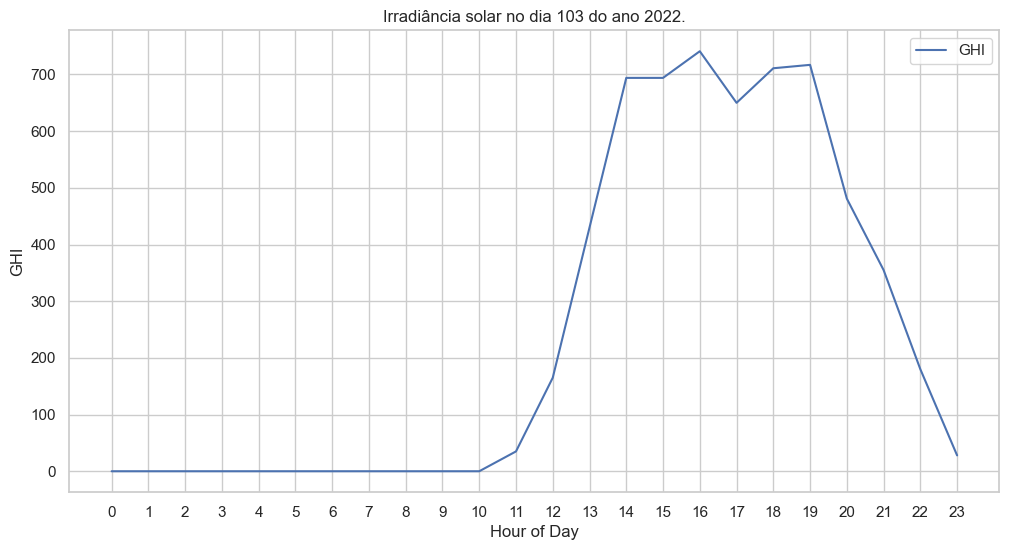

In [431]:
df_random_day.plot(
	x='HourOfDay',
	y='GHI',
	figsize=(12, 6),
	title=f'Irradiância solar no dia {random_day} do ano {year_of_day}.'
)
plt.xlabel('Hour of Day')
plt.ylabel('GHI')
plt.xticks(df_random_day['HourOfDay'])
plt.show()

In [432]:
df_train, df_test = data_preprocessing_scaling_split(df)


# Definição dos modelos.

In [433]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers=num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Camadas de regularização
        self.dropout1 = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout * 0.5)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Inicialização dos pesos
        self.init_weights()
        
    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x)
        
        # Pega apenas a última saída da sequência
        out = lstm_out[:, -1, :]
        
        # Regularização e camadas densas
        out = self.dropout1(out)
        out = self.batch_norm(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.fc2(out)
        
        return out

In [434]:
def train_model(model, train_loader, val_loader, test_loader, epochs, lr, patience=15, weight_decay=1e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    """Treina o modelo com early stopping e regularização"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    test_losses = []
    best_model_state = None
    
    for epoch in range(epochs):
        # Treino
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            
            # Gradient clipping para evitar exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validação
        model.eval()
        val_loss = 0
        test_loss = 0
        
        with torch.no_grad():
            # Loss de validação
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs.squeeze(), y_batch).item()
            
            # Loss de teste
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                test_loss += criterion(outputs.squeeze(), y_batch).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        test_loss /= len(test_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        
        scheduler.step(val_loss)
        
        # Early stopping baseado na validação
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Salva o melhor modelo
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping na época {epoch+1}")
                break
        
        # Print do progresso a cada 20 épocas
        if (epoch + 1) % 20 == 0:
            print(f'Época {epoch+1}/{epochs}: Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Test Loss: {test_loss:.6f}')
    
    # Carrega o melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, val_losses, test_losses, best_val_loss

In [435]:
# Prepare features and target for a simple univariate LSTM (e.g., predicting GHI from previous GHI)
# Here, we use GHI as both input and target for demonstration (1-step prediction)
ghi_values = torch.tensor(df_train['GHI'].values, dtype=torch.float32).unsqueeze(-1)
# Create sequences for LSTM (sequence length = 1 for simplicity)
X = ghi_values[:-1].unsqueeze(1)  # shape: (N-1, 1, 1)
y = ghi_values[1:]                # shape: (N-1, 1)

from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = LSTMModel(input_size=X.shape[1], hidden_size=2, output_size=1).to(device)
# For demonstration, use train_loader as val_loader and test_loader
train_losses, val_losses, test_losses, best_val_loss = train_model(
    model, train_loader, val_loader=train_loader, test_loader=train_loader, 
    epochs=200, lr=0.001, weight_decay=1e-5
)


c:\Users\Ric\projects\Estudos\ENGA74-TrabalhoFinal\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Ric\projects\Estudos\ENGA74-TrabalhoFinal\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Época 20/200: Train Loss: 0.071782, Val Loss: 0.071770, Test Loss: 0.071769
Early stopping na época 30



--- Análise de Overfitting ---


Text(0, 0.5, 'Loss')

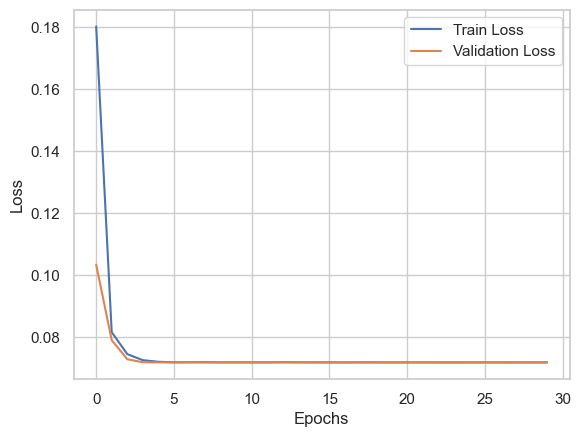

In [438]:
print("\n--- Análise de Overfitting ---")
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
final_test_loss = test_losses[-1]
sns.lineplot(x=range(len(train_losses)), y=train_losses, label='Train Loss')
sns.lineplot(x=range(len(val_losses)), y=val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
